In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

# Models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier


In [ ]:
@dataclass
class Config:
    ticker: str = "AAPL"
    benchmark: str = "SPY"
    start: str = "2010-01-01"
    end: str = None  # or "2025-12-31"
    trading_cost_bps: float = 5  # 5 bps = 0.05% per trade
    horizon_days: int = 1        # prediction horizon (1 or 5)

cfg = Config()


In [ ]:
# !pip install yfinance
import yfinance as yf

def load_ohlcv(ticker: str, start: str, end: str = None) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)
    df = df.rename(columns=str.lower)
    df.index = pd.to_datetime(df.index)
    return df

aapl = load_ohlcv(cfg.ticker, cfg.start, cfg.end)
spy = load_ohlcv(cfg.benchmark, cfg.start, cfg.end)

aapl.head(), spy.head()


(Price      adj close     close      high       low      open     volume
 Ticker          aapl      aapl      aapl      aapl      aapl       aapl
 Date                                                                   
 2010-01-04  6.418384  7.643214  7.660714  7.585000  7.622500  493729600
 2010-01-05  6.429479  7.656429  7.699643  7.616071  7.664286  601904800
 2010-01-06  6.327210  7.534643  7.686786  7.526786  7.656429  552160000
 2010-01-07  6.315514  7.520714  7.571429  7.466071  7.562500  477131200
 2010-01-08  6.357502  7.570714  7.571429  7.466429  7.510714  447610800,
 Price       adj close       close        high         low        open  \
 Ticker            spy         spy         spy         spy         spy   
 Date                                                                    
 2010-01-04  85.027931  113.330002  113.389999  111.510002  112.370003   
 2010-01-05  85.253052  113.629997  113.680000  112.849998  113.260002   
 2010-01-06  85.313034  113.709999  113.98999

In [ ]:
def align_data(stock: pd.DataFrame, bench: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(index=stock.index)
    # Use adjusted close for returns (splits/dividends handled)
    df["aapl_adjclose"] = stock["adj close"]
    df["aapl_volume"] = stock["volume"]
    df["spy_adjclose"] = bench["adj close"]
    df = df.dropna()
    return df

df = align_data(aapl, spy)
df.head()


,aapl_adjclose,aapl_volume,spy_adjclose
Date,,,
2010-01-04,6.418384,493729600,85.027931
2010-01-05,6.429479,601904800,85.253052
2010-01-06,6.327210,552160000,85.313034
2010-01-07,6.315514,477131200,85.673180
2010-01-08,6.357502,447610800,85.958275


In [ ]:
def add_returns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["aapl_ret"] = np.log(out["aapl_adjclose"]).diff()
    out["spy_ret"] = np.log(out["spy_adjclose"]).diff()
    out["excess_ret"] = out["aapl_ret"] - out["spy_ret"]
    return out.dropna()

df = add_returns(df)
df[["aapl_ret","spy_ret","excess_ret"]].describe()


,aapl_ret,spy_ret,excess_ret
count,4041.000000,4041.000000,4041.000000
mean,0.000913,0.000520,0.000393
std,0.017722,0.010848,0.012913
min,-0.137708,-0.115887,-0.132152
25%,-0.007420,-0.003711,-0.006195
50%,0.000970,0.000708,0.000200
75%,0.010185,0.005773,0.007029
max,0.142617,0.099863,0.091692


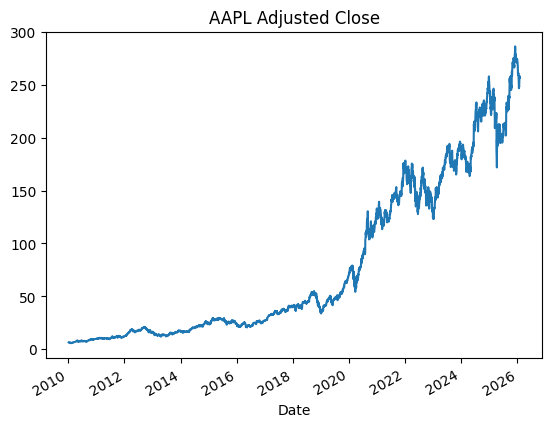

In [ ]:
plt.figure()
df["aapl_adjclose"].plot(title="AAPL Adjusted Close")
plt.show()


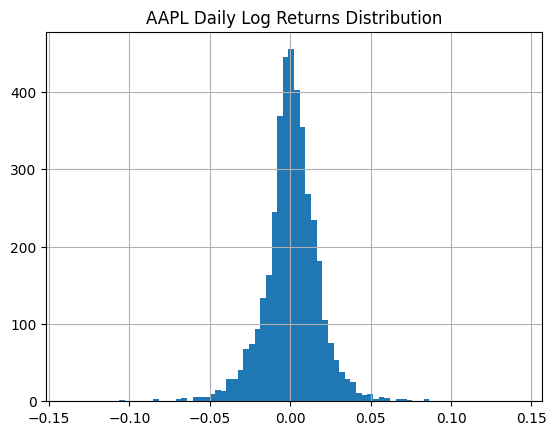

In [ ]:
plt.figure()
df["aapl_ret"].hist(bins=80)
plt.title("AAPL Daily Log Returns Distribution")
plt.show()


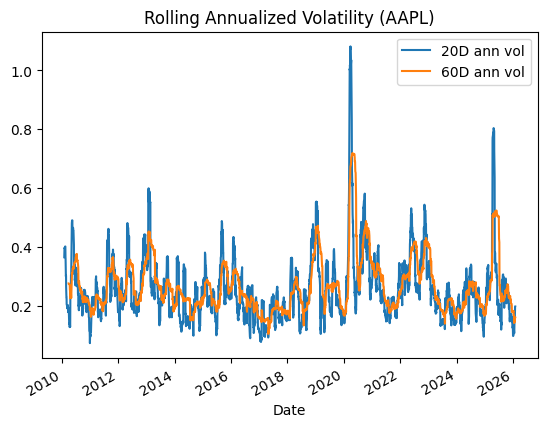

In [ ]:
vol20 = df["aapl_ret"].rolling(20).std() * np.sqrt(252)
vol60 = df["aapl_ret"].rolling(60).std() * np.sqrt(252)

plt.figure()
vol20.plot(label="20D ann vol")
vol60.plot(label="60D ann vol")
plt.legend()
plt.title("Rolling Annualized Volatility (AAPL)")
plt.show()


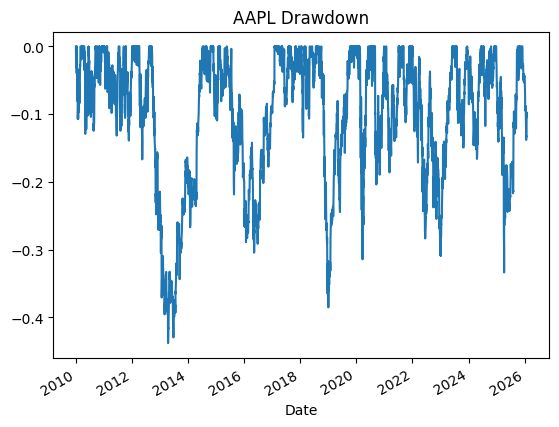

-0.4379715693311429

In [ ]:
def compute_drawdown(price: pd.Series) -> pd.DataFrame:
    running_max = price.cummax()
    dd = price / running_max - 1.0
    return pd.DataFrame({"price": price, "running_max": running_max, "drawdown": dd})

dd = compute_drawdown(df["aapl_adjclose"])

plt.figure()
dd["drawdown"].plot(title="AAPL Drawdown")
plt.show()

dd["drawdown"].min()


In [ ]:
df2 = df.copy()
df2["vol20"] = df2["aapl_ret"].rolling(20).std() * np.sqrt(252)
thr = df2["vol20"].median()
df2["regime_high_vol"] = (df2["vol20"] > thr).astype(int)
df2 = df2.dropna()

df2["regime_high_vol"].value_counts()


,count
regime_high_vol,
1,2011
0,2011


In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Lags of returns
    for k in range(1, 11):
        out[f"ret_lag_{k}"] = out["aapl_ret"].shift(k)
        out[f"spy_ret_lag_{k}"] = out["spy_ret"].shift(k)

    # Rolling stats
    out["ret_mean_5"] = out["aapl_ret"].rolling(5).mean()
    out["ret_mean_20"] = out["aapl_ret"].rolling(20).mean()
    out["vol_5"] = out["aapl_ret"].rolling(5).std()
    out["vol_20"] = out["aapl_ret"].rolling(20).std()

    # Momentum vs moving averages (on price)
    price = out["aapl_adjclose"]
    out["ma20"] = price.rolling(20).mean()
    out["ma50"] = price.rolling(50).mean()
    out["ma200"] = price.rolling(200).mean()
    out["mom_20"] = price / out["ma20"] - 1
    out["mom_50"] = price / out["ma50"] - 1
    out["mom_200"] = price / out["ma200"] - 1

    # Volume features (simple)
    out["vol_avg_20"] = out["aapl_volume"].rolling(20).mean()
    out["vol_spike"] = (out["aapl_volume"] > 1.5 * out["vol_avg_20"]).astype(int)

    return out.dropna()

feat_df = make_features(df2)
feat_df.shape


(3823, 40)

In [ ]:
H = cfg.horizon_days

feat_df["fwd_ret"] = feat_df["aapl_ret"].shift(-H)
feat_df["target_up"] = (feat_df["fwd_ret"] > 0).astype(int)

feat_df = feat_df.dropna()
feat_df[["fwd_ret","target_up"]].head()


,fwd_ret,target_up
Date,,
2010-11-15,-0.017910,0
2010-11-16,-0.003621,0
2010-11-17,0.026047,1
2010-11-18,-0.005527,0
2010-11-19,0.021385,1


In [ ]:
feature_cols = [c for c in feat_df.columns if c.startswith(("ret_lag_","spy_ret_lag_","ret_mean_","vol_","mom_","vol_spike"))]
X = feat_df[feature_cols]
y = feat_df["target_up"]

split_idx = int(len(feat_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [ ]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, pred))
print("AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))


Accuracy: 0.49673202614379086
AUC: 0.46453871385650103
              precision    recall  f1-score   support

           0       0.38      0.18      0.24       348
           1       0.53      0.76      0.62       417

    accuracy                           0.50       765
   macro avg       0.46      0.47      0.43       765
weighted avg       0.46      0.50      0.45       765



In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, pred_rf))
print("AUC:", roc_auc_score(y_test, proba_rf))


Accuracy: 0.5137254901960784
AUC: 0.4678670856418313


In [ ]:
def walk_forward_auc(model, X: pd.DataFrame, y: pd.Series, n_splits: int = 6) -> List[float]:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    aucs = []
    for train_idx, val_idx in tscv.split(X):
        Xtr, Xva = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yva = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(Xtr, ytr)
        p = model.predict_proba(Xva)[:,1]
        aucs.append(roc_auc_score(yva, p))
    return aucs

aucs_lr = walk_forward_auc(logreg, X_train, y_train, n_splits=6)
aucs_lr, np.mean(aucs_lr)


([np.float64(0.5266712960040401),
  np.float64(0.5179417026202252),
  np.float64(0.5245425439433453),
  np.float64(0.5128676470588235),
  np.float64(0.556124291145424),
  np.float64(0.4660480188540286)],
 np.float64(0.5173659166043144))

<Figure size 640x480 with 0 Axes>

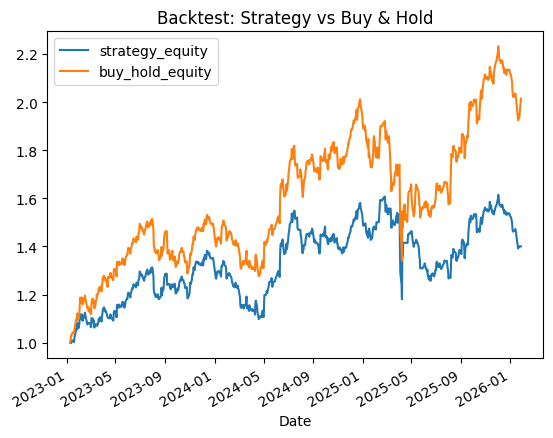

In [ ]:
def backtest_long_cash(prices: pd.Series, signal_up: pd.Series, cost_bps: float = 5) -> pd.DataFrame:
    # signal_up: 1 = long, 0 = cash
    ret = prices.pct_change().fillna(0.0)

    pos = signal_up.shift(1).fillna(0)  # trade at next open/day (simple)
    strat_ret = pos * ret

    # Transaction costs when position changes
    trades = pos.diff().abs().fillna(0)
    cost = trades * (cost_bps / 10000.0)
    strat_ret = strat_ret - cost

    equity = (1 + strat_ret).cumprod()
    bh = (1 + ret).cumprod()

    out = pd.DataFrame({
        "strategy_equity": equity,
        "buy_hold_equity": bh,
        "pos": pos,
        "ret": ret,
        "strat_ret": strat_ret
    })
    return out

# Use model predictions on test set
test_index = X_test.index
signal = pd.Series(pred_rf, index=test_index)  # 1/0 predictions
bt = backtest_long_cash(feat_df.loc[test_index, "aapl_adjclose"], signal, cost_bps=cfg.trading_cost_bps)

plt.figure()
bt[["strategy_equity","buy_hold_equity"]].plot(title="Backtest: Strategy vs Buy & Hold")
plt.show()


In [ ]:
def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1
    return dd.min()

def sharpe(daily_ret: pd.Series) -> float:
    if daily_ret.std() == 0:
        return 0.0
    return (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)

print("Strategy total return:", bt["strategy_equity"].iloc[-1] - 1)
print("Buy&Hold total return:", bt["buy_hold_equity"].iloc[-1] - 1)
print("Strategy MDD:", max_drawdown(bt["strategy_equity"]))
print("Buy&Hold MDD:", max_drawdown(bt["buy_hold_equity"]))
print("Strategy Sharpe:", sharpe(bt["strat_ret"]))
print("Buy&Hold Sharpe:", sharpe(bt["ret"]))


Strategy total return: 0.40011886356621895
Buy&Hold total return: 1.0143398394619672
Strategy MDD: -0.2653849908649578
Buy&Hold MDD: -0.3336051095989373
Strategy Sharpe: 0.5943047252941142
Buy&Hold Sharpe: 1.0321730026466762


A) Past trend analysis visuals (EDA)
1) Price + Moving Averages (trend context)

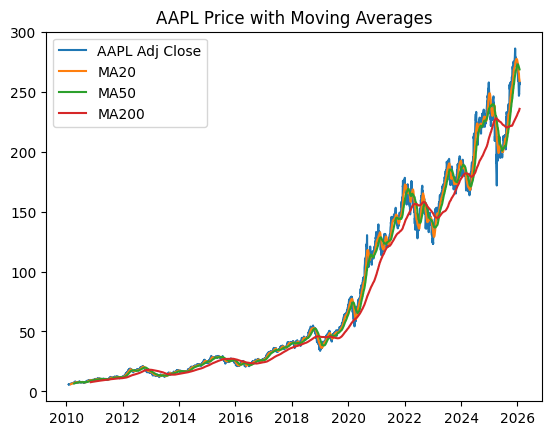

In [ ]:
plt.figure()
plt.plot(df2.index, df2["aapl_adjclose"], label="AAPL Adj Close")
plt.plot(df2.index, df2["aapl_adjclose"].rolling(20).mean(), label="MA20")
plt.plot(df2.index, df2["aapl_adjclose"].rolling(50).mean(), label="MA50")
plt.plot(df2.index, df2["aapl_adjclose"].rolling(200).mean(), label="MA200")
plt.title("AAPL Price with Moving Averages")
plt.legend()
plt.show()


2) Cumulative returns (buy & hold growth curve)

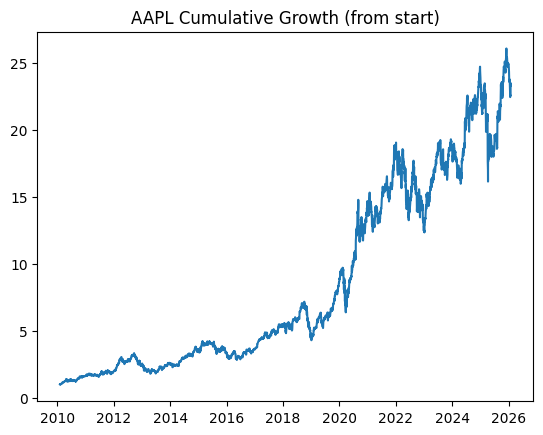

In [ ]:
cum = (1 + df2["aapl_ret"].fillna(0)).cumprod()
plt.figure()
plt.plot(df2.index, cum)
plt.title("AAPL Cumulative Growth (from start)")
plt.show()


3) Rolling returns (20D / 60D / 252D)

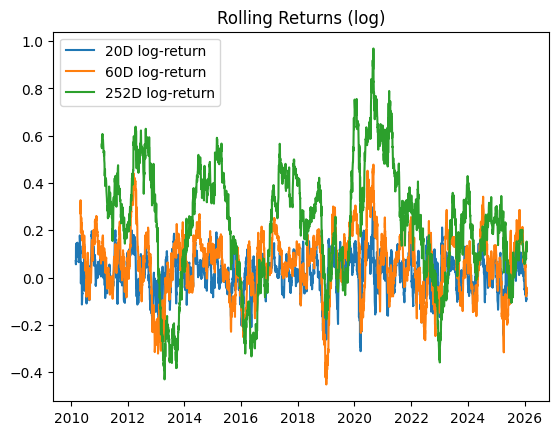

In [ ]:
plt.figure()
plt.plot(df2.index, df2["aapl_ret"].rolling(20).sum(), label="20D log-return")
plt.plot(df2.index, df2["aapl_ret"].rolling(60).sum(), label="60D log-return")
plt.plot(df2.index, df2["aapl_ret"].rolling(252).sum(), label="252D log-return")
plt.title("Rolling Returns (log)")
plt.legend()
plt.show()


Monthly returns heatmap (super clean “trend over years” visual)

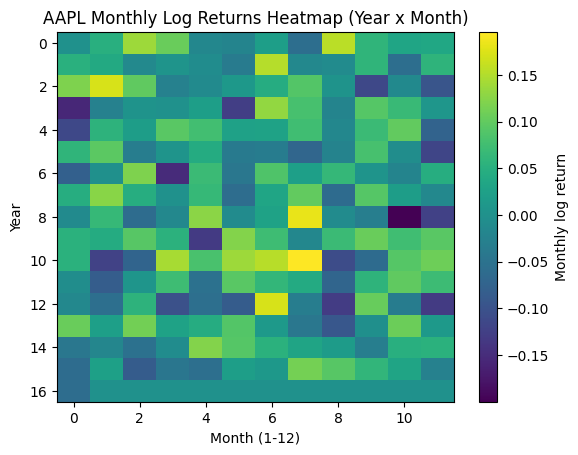

In [ ]:
tmp = df2[["aapl_ret"]].copy()
tmp["month"] = tmp.index.to_period("M")
monthly = tmp.groupby("month")["aapl_ret"].sum().to_timestamp()
heat = monthly.to_frame("ret")
heat["Year"] = heat.index.year
heat["Month"] = heat.index.month
pivot = heat.pivot(index="Year", columns="Month", values="ret")

plt.figure()
plt.imshow(pivot.fillna(0), aspect="auto")
plt.title("AAPL Monthly Log Returns Heatmap (Year x Month)")
plt.xlabel("Month (1-12)")
plt.ylabel("Year")
plt.colorbar(label="Monthly log return")
plt.show()


Predicted probability over time (super important)

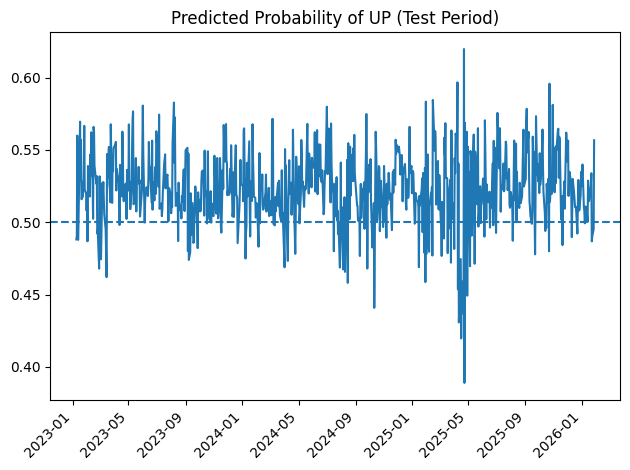

In [ ]:
proba_series = pd.Series(proba_rf, index=test_index)
plt.figure()
plt.plot(proba_series.index, proba_series.values)
plt.axhline(0.5, linestyle="--")
plt.title("Predicted Probability of UP (Test Period)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Actual forward return over time (compare “signal vs reality”)

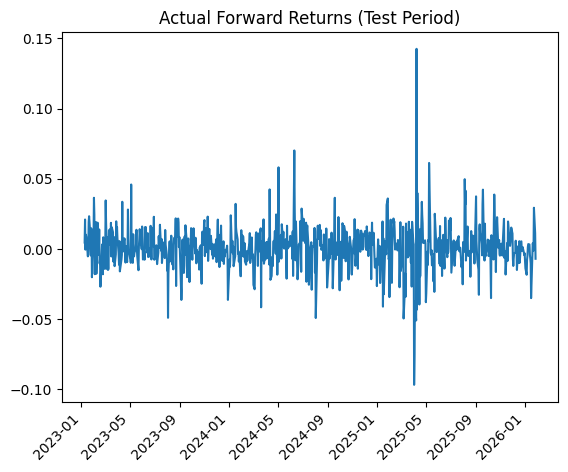

In [ ]:
actual_fwd = feat_df.loc[test_index, "fwd_ret"]
plt.figure()
plt.plot(actual_fwd.index, actual_fwd.values)
plt.title("Actual Forward Returns (Test Period)")
plt.xticks(rotation=45, ha='right')
plt.show()


“Lift” chart: do higher probabilities actually mean higher future returns?

This is a great trading-style visual.

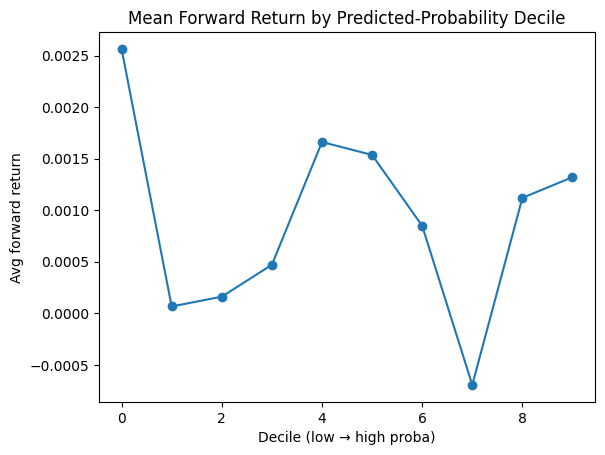

In [ ]:
tmp = pd.DataFrame({
    "proba": proba_rf,
    "fwd_ret": feat_df.loc[test_index, "fwd_ret"].values
}, index=test_index)

tmp["bucket"] = pd.qcut(tmp["proba"], 10, labels=False)  # deciles
lift = tmp.groupby("bucket")["fwd_ret"].mean()

plt.figure()
plt.plot(lift.index, lift.values, marker="o")
plt.title("Mean Forward Return by Predicted-Probability Decile")
plt.xlabel("Decile (low → high proba)")
plt.ylabel("Avg forward return")
plt.show()


Feature importance (what the model actually used)

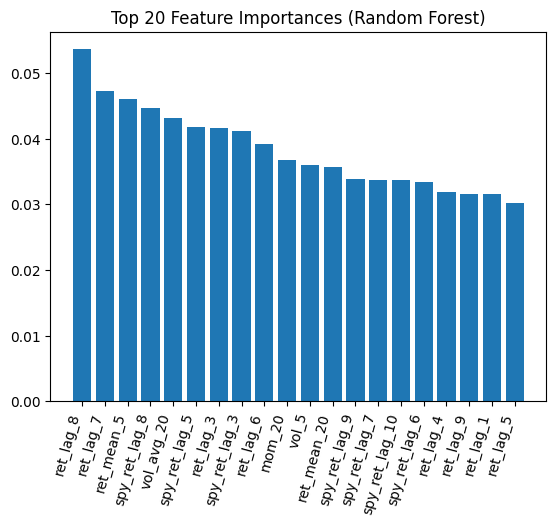

In [ ]:
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(20)

plt.figure()
plt.bar(imp.index, imp.values)
plt.xticks(rotation=75, ha="right")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()


For best storytelling:
Price + MAs

Drawdown plot

Rolling volatility (with threshold line)

Monthly returns heatmap

Predicted probability over time

Lift chart (deciles vs forward return)

Strategy equity vs buy-and-hold

Forecasting

In [ ]:
from prophet import Prophet

In [ ]:
prophet_df = df2[["aapl_adjclose"]].reset_index()

# rename the first column (date index) to 'ds' no matter what it's called
prophet_df = prophet_df.rename(columns={prophet_df.columns[0]: "ds"})

prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])
prophet_df["y"] = np.log(prophet_df["aapl_adjclose"])
prophet_df = prophet_df[["ds", "y"]].dropna()

prophet_df.head()


,ds,y
0,2010-02-02,1.770543
1,2010-02-03,1.787603
2,2010-02-04,1.750900
3,2010-02-05,1.768500
4,2010-02-08,1.761620


In [ ]:
split_idx = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:split_idx].copy()
test_df  = prophet_df.iloc[split_idx:].copy()

train_df["ds"].min(), train_df["ds"].max(), test_df["ds"].min(), test_df["ds"].max()


(Timestamp('2010-02-02 00:00:00'),
 Timestamp('2022-11-09 00:00:00'),
 Timestamp('2022-11-10 00:00:00'),
 Timestamp('2026-01-28 00:00:00'))

In [ ]:

m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode="additive"
)

m.fit(train_df)


Forecast (history + future)

In [ ]:
future_days = 60  # change to 30/90 if you want
future = m.make_future_dataframe(periods=future_days, freq="B")  # business days
forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
3272,2023-01-26,5.249639,5.137491,5.360266
3273,2023-01-27,5.248139,5.138463,5.357290
3274,2023-01-30,5.254368,5.140003,5.365391
3275,2023-01-31,5.256426,5.145299,5.366025
3276,2023-02-01,5.258600,5.143321,5.374436


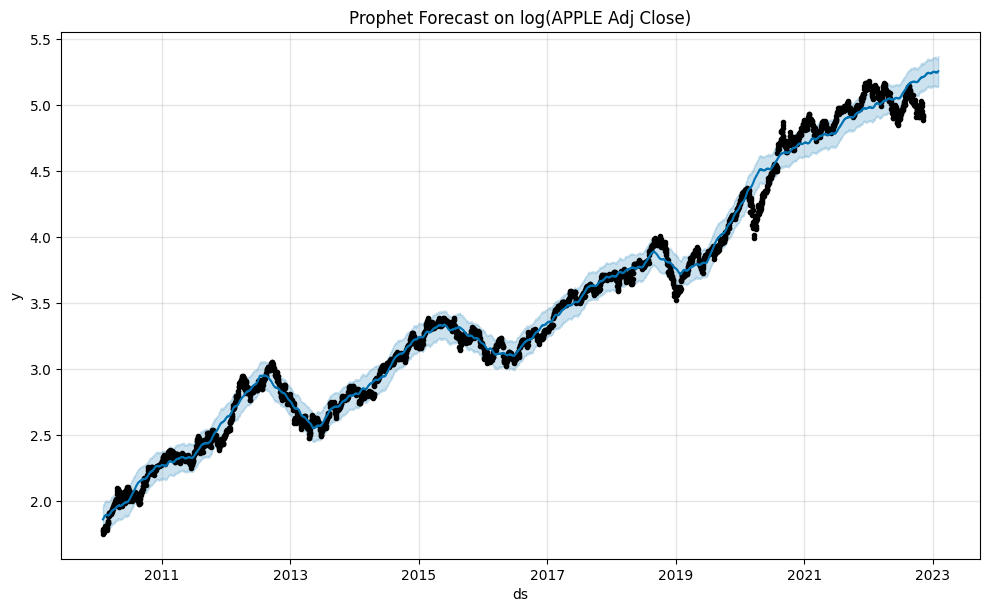

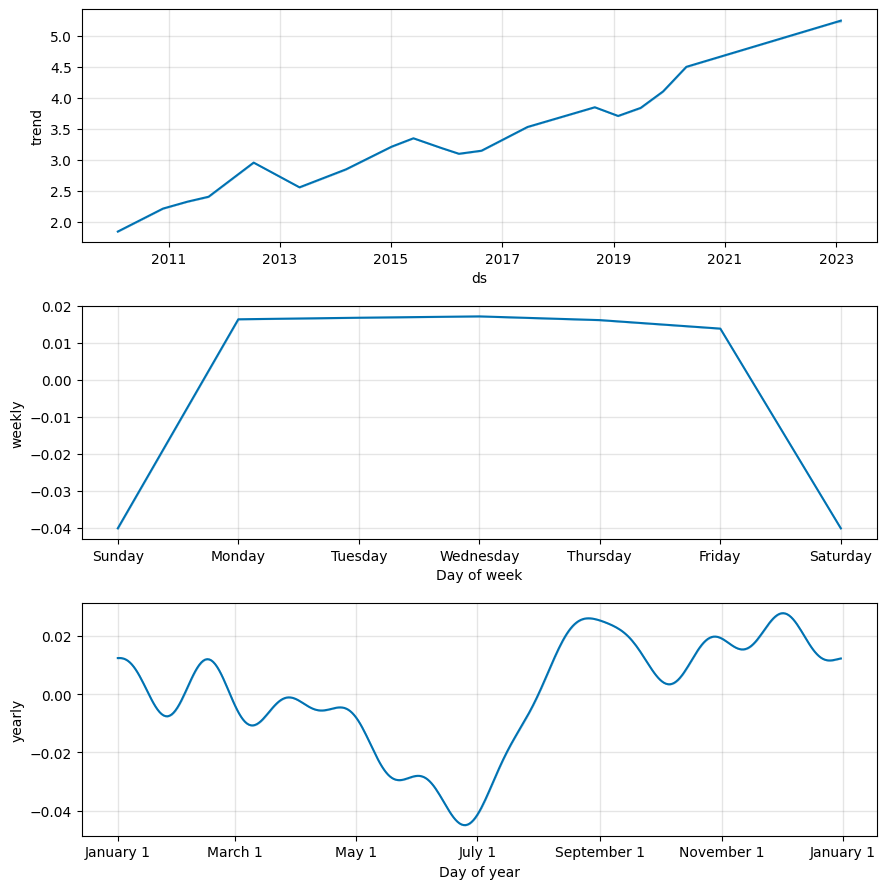

In [ ]:
fig1 = m.plot(forecast)
plt.title("Prophet Forecast on log(APPLE Adj Close)")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()


Visual: Actual vs Predicted (TEST period) + uncertainty band

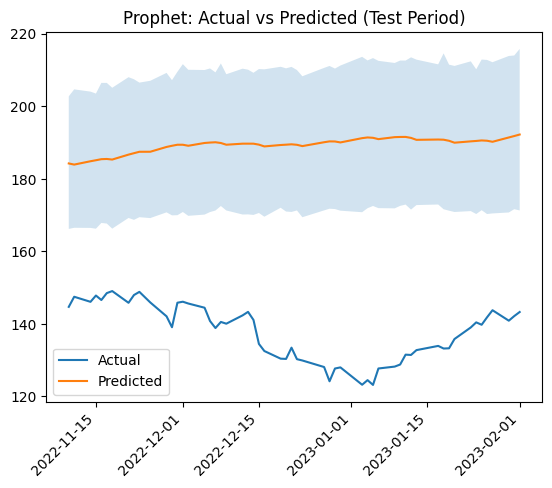

In [ ]:
fc = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].copy()

test_plot = test_df.set_index("ds").join(fc, how="left").dropna()

# convert back from log price to price for interpretation
test_plot["actual_price"] = np.exp(test_plot["y"])
test_plot["pred_price"] = np.exp(test_plot["yhat"])
test_plot["pred_low"] = np.exp(test_plot["yhat_lower"])
test_plot["pred_high"] = np.exp(test_plot["yhat_upper"])

plt.figure()
plt.plot(test_plot.index, test_plot["actual_price"], label="Actual")
plt.plot(test_plot.index, test_plot["pred_price"], label="Predicted")
plt.fill_between(test_plot.index, test_plot["pred_low"], test_plot["pred_high"], alpha=0.2)
plt.title("Prophet: Actual vs Predicted (Test Period)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [ ]:
rmse = np.sqrt(np.mean((test_plot["actual_price"] - test_plot["pred_price"])**2))
mape = np.mean(np.abs((test_plot["actual_price"] - test_plot["pred_price"]) / test_plot["actual_price"])) * 100

print("RMSE:", rmse)
print("MAPE%:", mape)


RMSE: 52.34345402074368
MAPE%: 37.898072702781896


Adding Prophet features back into the dataset

In [ ]:
# Make a copy of df2 with a 'ds' column for merging
df2_prophet = df2.copy().reset_index()
df2_prophet = df2_prophet.rename(columns={df2_prophet.columns[0]: "ds"})
df2_prophet["ds"] = pd.to_datetime(df2_prophet["ds"])

# Merge prophet predictions (log space)
df2_prophet = df2_prophet.merge(
    forecast[["ds", "yhat"]],
    on="ds",
    how="left"
)

# Prophet-based features (log-space)
df2_prophet["log_price"] = np.log(df2_prophet["aapl_adjclose"])
df2_prophet["prophet_trend_gap"] = df2_prophet["log_price"] - df2_prophet["yhat"]  # above/below trend
df2_prophet["prophet_trend_slope"] = df2_prophet["yhat"].diff()                     # trend slope

df2_prophet = df2_prophet.set_index("ds").dropna()
df2_prophet[["prophet_trend_gap", "prophet_trend_slope"]].head()


,prophet_trend_gap,prophet_trend_slope
ds,,
2010-02-03,-0.074444,0.002984
2010-02-04,-0.112840,0.001692
2010-02-05,-0.095688,0.000448
2010-02-08,-0.113261,0.010694
2010-02-09,-0.105656,0.003002


In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Lags of returns
    for k in range(1, 11):
        out[f"ret_lag_{k}"] = out["aapl_ret"].shift(k)
        out[f"spy_ret_lag_{k}"] = out["spy_ret"].shift(k)

    # Rolling stats
    out["ret_mean_5"] = out["aapl_ret"].rolling(5).mean()
    out["ret_mean_20"] = out["aapl_ret"].rolling(20).mean()
    out["vol_5"] = out["aapl_ret"].rolling(5).std()
    out["vol_20"] = out["aapl_ret"].rolling(20).std()

    # Momentum vs moving averages (on price)
    price = out["aapl_adjclose"]
    out["ma20"] = price.rolling(20).mean()
    out["ma50"] = price.rolling(50).mean()
    out["ma200"] = price.rolling(200).mean()
    out["mom_20"] = price / out["ma20"] - 1
    out["mom_50"] = price / out["ma50"] - 1
    out["mom_200"] = price / out["ma200"] - 1

    # Volume features (simple)
    out["vol_avg_20"] = out["aapl_volume"].rolling(20).mean()
    out["vol_spike"] = (out["aapl_volume"] > 1.5 * out["vol_avg_20"]).astype(int)

    # Prophet features (only works if df contains these columns) ----
    if "prophet_trend_gap" in out.columns and "prophet_trend_slope" in out.columns:
        out["prophet_gap"] = out["prophet_trend_gap"]
        out["prophet_slope"] = out["prophet_trend_slope"]
        out["prophet_gap_lag_1"] = out["prophet_gap"].shift(1)
        out["prophet_slope_lag_1"] = out["prophet_slope"].shift(1)


    return out.dropna()


In [ ]:
#feat_df = make_features(df2)
feat_df = make_features(df2_prophet)
feat_df.shape

(3073, 48)

In [ ]:
H = getattr(cfg, "horizon_days", 1)  # 1-day ahead by default

# forward return (log return) for horizon H
feat_df["fwd_ret"] = feat_df["aapl_ret"].shift(-H)
feat_df["target_up"] = (feat_df["fwd_ret"] > 0).astype(int)

feat_df = feat_df.dropna()
feat_df[["fwd_ret", "target_up"]].head()


,fwd_ret,target_up
ds,,
2010-11-16,-0.003621,0
2010-11-17,0.026047,1
2010-11-18,-0.005527,0
2010-11-19,0.021385,1
2010-11-22,-0.014886,0


In [ ]:
feature_cols = [c for c in feat_df.columns if c.startswith((
    "ret_lag_",
    "spy_ret_lag_",
    "ret_mean_",
    "vol_",
    "mom_",
    "vol_spike",
    "prophet"     # <-- this includes prophet_gap, prophet_slope, lags
))]

len(feature_cols), feature_cols[:10]


(35,
 ['prophet_trend_gap',
  'prophet_trend_slope',
  'ret_lag_1',
  'spy_ret_lag_1',
  'ret_lag_2',
  'spy_ret_lag_2',
  'ret_lag_3',
  'spy_ret_lag_3',
  'ret_lag_4',
  'spy_ret_lag_4'])

train/test split time based

In [ ]:
X = feat_df[feature_cols]
y = feat_df["target_up"]

split_idx = int(len(feat_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((2457, 35), (615, 35))

train logistic regression + evaluate

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

logreg.fit(X_train, y_train)

pred_lr = logreg.predict(X_test)
proba_lr = logreg.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred_lr))
print("AUC:", roc_auc_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr))


Accuracy: 0.4959349593495935
AUC: 0.5387829803440323
              precision    recall  f1-score   support

           0       0.49      0.62      0.55       302
           1       0.51      0.38      0.43       313

    accuracy                           0.50       615
   macro avg       0.50      0.50      0.49       615
weighted avg       0.50      0.50      0.49       615



Visual: predicted probability over time (test period)

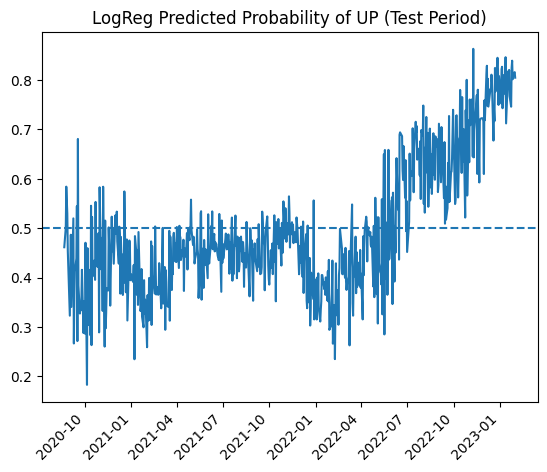

In [ ]:
test_index = X_test.index
proba_series = pd.Series(proba_lr, index=test_index)

plt.figure()
plt.plot(proba_series.index, proba_series.values)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.5, linestyle="--")
plt.title("LogReg Predicted Probability of UP (Test Period)")
plt.show()


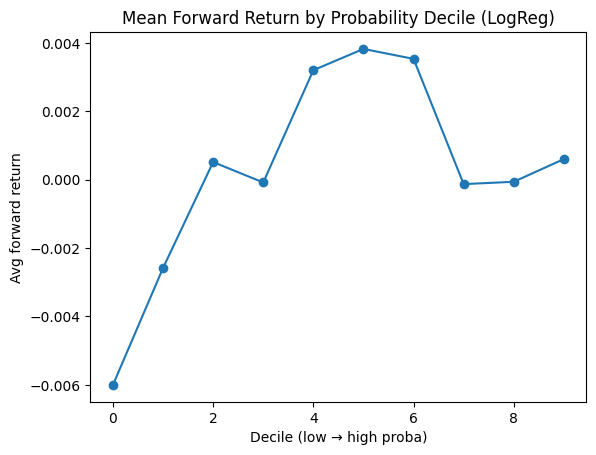

In [ ]:
tmp = pd.DataFrame({
    "proba": proba_lr,
    "fwd_ret": feat_df.loc[test_index, "fwd_ret"].values
}, index=test_index)

tmp["bucket"] = pd.qcut(tmp["proba"], 10, labels=False)  # deciles
lift = tmp.groupby("bucket")["fwd_ret"].mean()

plt.figure()
plt.plot(lift.index, lift.values, marker="o")
plt.title("Mean Forward Return by Probability Decile (LogReg)")
plt.xlabel("Decile (low → high proba)")
plt.ylabel("Avg forward return")
plt.show()


Backtest (LogReg signal → long/cash)

<Figure size 640x480 with 0 Axes>

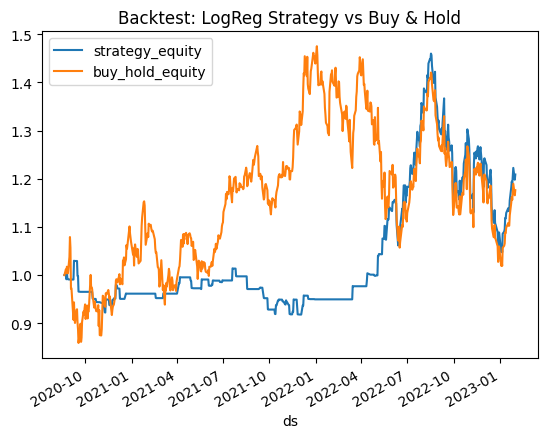

Strategy total return: 0.2087076539083179
Buy&Hold total return: 0.1761197561138983
Strategy MDD: -0.28257013937435593
Buy&Hold MDD: -0.30912809015192155
Strategy Sharpe: 0.48557065317607084
Buy&Hold Sharpe: 0.3673925002640449


In [ ]:
signal = pd.Series(pred_lr, index=test_index)  # 1=long, 0=cash

bt = backtest_long_cash(
    prices=feat_df.loc[test_index, "aapl_adjclose"],
    signal_up=signal,
    cost_bps=getattr(cfg, "trading_cost_bps", 5)
)

plt.figure()
bt[["strategy_equity", "buy_hold_equity"]].plot(title="Backtest: LogReg Strategy vs Buy & Hold")
plt.show()

print("Strategy total return:", bt["strategy_equity"].iloc[-1] - 1)
print("Buy&Hold total return:", bt["buy_hold_equity"].iloc[-1] - 1)
print("Strategy MDD:", max_drawdown(bt["strategy_equity"]))
print("Buy&Hold MDD:", max_drawdown(bt["buy_hold_equity"]))
print("Strategy Sharpe:", sharpe(bt["strat_ret"]))
print("Buy&Hold Sharpe:", sharpe(bt["ret"]))


Prophet gap vs forward returns

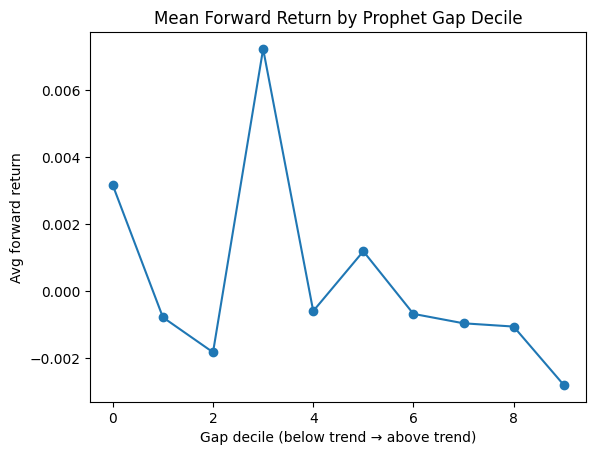

In [ ]:
gap_test = feat_df.loc[test_index, "prophet_gap"]
tmp2 = pd.DataFrame({
    "prophet_gap": gap_test.values,
    "fwd_ret": feat_df.loc[test_index, "fwd_ret"].values
}, index=test_index)

tmp2["gap_bucket"] = pd.qcut(tmp2["prophet_gap"], 10, labels=False)
gap_lift = tmp2.groupby("gap_bucket")["fwd_ret"].mean()

plt.figure()
plt.plot(gap_lift.index, gap_lift.values, marker="o")
plt.title("Mean Forward Return by Prophet Gap Decile")
plt.xlabel("Gap decile (below trend → above trend)")
plt.ylabel("Avg forward return")
plt.show()
